<img style="float: left;" src="earth-lab-logo-rgb.png" width="150" height="150" />

# Earth Analytics Education - EA  Python Course Spring 2021

## Important  - Assignment Guidelines

1. Before you submit your assignment to GitHub, make sure to run the entire notebook with a fresh kernel. To do this first, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Always replace the `raise NotImplementedError()` code with your code that addresses the activity challenge. If you don't replace that code, your notebook will not run.

```
# YOUR CODE HERE
raise NotImplementedError()
```

3. Any open ended questions will have a "YOUR ANSWER HERE" within a markdown cell. Replace that text with your answer also formatted using Markdown.
4. **DO NOT RENAME THIS NOTEBOOK File!** If the file name changes, the autograder will not grade your assignment properly.
6. When you create a figure, comment out `plt.show()` to ensure the autograder can grade your plots. For figure cells, DO NOT DELETE the code that says `DO NOT REMOVE LINE BELOW`.

```
### DO NOT REMOVE LINE BELOW ###
student_plot1_ax = nb.convert_axes(plt)
```

* Only include the package imports, code, and outputs that are required to run your homework assignment.
* Be sure that your code can be run on any operating system. This means that:
   1. the data should be downloaded in the notebook to ensure it's reproducible
   2. all paths should be created dynamically using the `os.path.join`

## Follow to PEP 8 Syntax Guidelines & Documentation

* Run the `autopep8` tool on all cells prior to submitting (HINT: hit shift + the tool to run it on all cells at once!
* Use clear and expressive names for variables. 
* Organize your code to support readability.
* Check for code line length
* Use comments and white space sparingly where it is needed
* Make sure all python imports are at the top of your notebook and follow PEP 8 order conventions
* Spell check your Notebook before submitting it.

For all of the plots below, be sure to do the following:

* Make sure each plot has a clear TITLE and, where appropriate, label the x and y axes. Be sure to include UNITS in your labels.


### Add Your Name Below 
**Your Name: Svetlana Kurakina**

<img style="float: left;" src="colored-bar.png"/>

---

# Week 04 and 05 Homework - Automate NDVI Workflow

For this assignment, you will write code to generate a plot of the mean normalized difference vegetation index (NDVI) for two different sites in the United States across one year of data:

* San Joaquin Experimental Range (SJER) in Southern California, United States
* Harvard Forest (HARV) in the Northeastern United States

The data that you will use for this week is available from **earthpy** using the following download: 

`et.data.get_data('ndvi-automation')`

## Assignment Goals

Your goal in this assignment is to create the most efficient and concise workflow that you can that allows for:

1. The code to scale if you added new sites or more time periods to the analysis.
2. Someone else to understand your workflow.
3. The LEAST and most efficient (i.e. runs fast, minimize repetition) amount of code that completes the task.

### HINTS

* Remove values outside of the landsat valid range of values as specified in the metadata, as needed.
* Keep any output files SEPARATE FROM input files. Outputs should be created in an outputs directory that is created in the code (if needed) and/or tested for.
* Use the functions that we demonstrated during class to make your workflow more efficient.
* BONUS - if you  chose - you can export your data as a csv file. You will get bonus points for doing this.


## Assignment Requirements

Your submission to the GitHub repository should include:
* This Jupyter Notebook file (.ipynb) with:
    * The code to create a plot of mean NDVI across a year for  2 NEON Field Sites:
        * NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object
    * The **data should be cleaned to remove the influence of clouds**. See the [earthdatascience website for an example of what your plot might look like with and without removal of clouds](https://www.earthdatascience.org/courses/earth-analytics-python/create-efficient-data-workflows/).
* BONUS: Create one output `.csv` file that has 3 columns - NDVI, Date and Site Name - with values for SJER and HARV.

Your notebook should:
* Have *at least* 2 well documented and well named functions with docstrings.
* Include a Markdown cell at the top of the notebook that outlines the overall workflow using pseudocode (i.e. plain language, not code)
* Include additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

# Replace this cell with your pseudocode  for this workflow

If you happen to be a diagram person a diagram is ok too



# Pseudocode for this workflow
* Import libraries necessary to complete the workflow
* Set home directory
* Set paths to data
* Specify cloud values using earthpy (need to do once)
* Read study sites boundaries (need to do once for each site)
* Read landsat bands and qa layers
* Restrict landsat data to "valid range" of 0 to 10000
* Clip extent of bands to match study sites boundaries
* Clip extent of qa layers to match study sites boundaries
* Calculate NDVI for each pair of red/infrared bands for each landsar scene
* Apply cloud mask to resulting NDVI
* Calculate Mean NDVI and append those to a list
* Get site names from paths and append those to a list
* Get scene dates from from paths and append those to a list
* Create dataframe and populate  with lists of site names, dates, mean NDVIs
* Set dataframe index to datetime
* Drop NA data
* Plot data
* Export data to CSV

In [1]:
# Autograding imports - do not modify this cell
import matplotcheck.autograde as ag
import matplotcheck.notebook as nb
import matplotcheck.timeseries as ts
from datetime import datetime

In [2]:
# Import needed packages in PEP 8 order
# and no unused imports listed (10 points total)

# YOUR CODE HERE
import os
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import pandas as  pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.mask as em
import earthpy.spatial as es
import earthpy.plot as ep

# Download data and set working directory
data = et.data.get_data('ndvi-automation')
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))


In [3]:
# DO NOT MODIFY THIS CELL
# Tests that the working directory is set to earth-analytics/data

path = os.path.normpath(os.getcwd())
student_wd_parts = path.split(os.sep)

if student_wd_parts[-2:] == ['earth-analytics', 'data']:
    print("\u2705 Great - it looks like your working directory is set correctly to ~/earth-analytics/data")
else:
    print("\u274C Oops, the autograder will not run unless your working directory is set to earth-analytics/data")

✅ Great - it looks like your working directory is set correctly to ~/earth-analytics/data


# Figure 1: Plot 1 - Mean NDVI For Each Site Across the Year (50 points)

Create a plot of the mean normalized difference vegetation index (NDVI) for the two different sites in the United States across the year: 

* NDVI on the x axis and formatted dates on the y for both NEON sites on one figure/axis object.
* Each site should be identified with a different color in the plot and legend.
* The final plot **data should be cleaned to remove the influence of clouds**.
* Be sure to include appropriate title and axes labels.

Add additional cells as needed for processing data (e.g. defining functions, etc), but be sure to:
* follow the instructions in the code cells that have been provided to ensure that you are able to use the sanity check tests that are provided. 
* include only the plot code in the cell identified for the final plot code below

# MEAN NDVI for one HARV landsat scene without functions (below)
* I want to be sure I understand all the transformations and calculations involved in the process
* To achieve that, I start from processing all data for one HARV landsat scene without using any functions
* I check my resulting dataframe using autograder below to make sure I am getting correct result
* After that, I adjust my pseudocode and start working on functions
* Once I get my functions I will use them to calculate df for single HARV landsat scene again
* Once I am sure my functions work as intended, I will comment out code cell below, but I leave it for future reference

In [4]:
# # Calculation Mean NDVI for one HARV landsat scene without functions

# # Set paths 
# path_harv = os.path.join('ndvi-automation', 'sites', 'HARV')
# path_harv_scene = os.path.join(path_harv,'landsat-crop', 
#                                'LC080130302017031701T1-SC20181023151837')
# path_harv_bands = sorted(glob(os.path.join(path_harv_scene,
#                                            '*band*[4-5].tif')))
# path_harv_crop_bound = os.path.join(path_harv, 'vector', 'HARV-crop.shp')
# path_harv_qa = os.path.join(
#     path_harv_scene, 
#     'LC08_L1TP_013030_20170317_20170328_01_T1_pixel_qa.tif'
# )

# # Open crop boundary
# harv_crop_bound = gpd.read_file(path_harv_crop_bound)

# # Open band 4 using rioxarray 
# harv_band_4 = rxr.open_rasterio(path_harv_bands[0], masked=True).squeeze()
# #harv_band_4.plot()

# # Clip band 4
# harv_band_4_crop = harv_band_4.rio.clip(harv_crop_bound.geometry)

# # Specify the valid range
# valid_range = (0, 10000)

# if valid_range:
#     mask = ((
#         harv_band_4_crop < valid_range[0]) | (
#         harv_band_4_crop > valid_range[1]))
#     harv_band_4_crop = harv_band_4_crop.where(~xr.where(mask, True, False))
#harv_band_4_crop.plot()
    
# # Open band 5 using rioxarray 
# harv_band_5 = rxr.open_rasterio(path_harv_bands[1], masked=True).squeeze()

# # Clip band 5
# harv_band_5_crop = harv_band_5.rio.clip(harv_crop_bound.geometry)

# # Specify the valid range for band 5

# if valid_range:
#     mask = ((
#         harv_band_5_crop < valid_range[0]) | (
#         harv_band_5_crop > valid_range[1]))
#     harv_band_5_crop = harv_band_5_crop.where(~xr.where(mask, True, False))
    
# #harv_band_5_crop.plot()

# # Calculate NDVI (since I used cropped bands it is already cropped)
# harv_ndvi = (harv_band_5_crop-harv_band_4_crop)/(
#     harv_band_5_crop+harv_band_4_crop)

# # Grab cloud values using earthpy
# high_cloud_confidence = (
#     em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"])
# cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
# cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]
# all_masked_values = cloud_shadow + cloud + high_cloud_confidence

# # Open and crop harv qa layer
# harv_qa = rxr.open_rasterio(path_harv_qa).squeeze()
# harv_qa_cropped = harv_qa.rio.clip(harv_crop_bound.geometry)

# Create and apply cloud mask to NDVI
# harv_ndvi_cl_free = harv_ndvi.where(
#     ~harv_qa_cropped.isin(all_masked_values))
#harv_ndvi_cl_free.plot()

# # Calculate mean NDVI
# print('My mean NDVI for HARV site is:', harv_ndvi_cl_free.mean().values)

# #Get site name from path
# harv_sitename = [os.path.basename(os.path.normpath(path_harv))]

# # Get date 
# harv_date = [os.path.basename(os.path.normpath(path_harv_scene))[10:18]]

# # Get NDVI value
# harv_mean = [harv_ndvi_cl_free.mean().values]

# # Construct dataframe
# harv_df = pd.DataFrame(columns=["site","date","mean_ndvi"])
# harv_df['site'] = harv_sitename
# harv_df['date'] = harv_date
# harv_df['mean_ndvi'] = harv_mean
# harv_df['date'] = pd.to_datetime(harv_df['date'])
# harv_df.set_index('date', inplace=True)
# harv_df

## Task 1: 

In the cell below, create a single dataframe containing MEAN NDVI, the site name, 
and the date of the data for the HARV site 
scene `HARV/landsat-crop/LC080130302017031701T1-SC20181023151837`.  The column names for the  final
DataFrame should be`mean_ndvi`, and `site`, and the data should be **indexed on the date**. 

Use the functions that we reviewed in class (or create your own versions of them) to implement your code

### In the Cell below Place  All Functions Needed to Run this Notebook (20 points)

In [5]:
### DO NOT REMOVE THIS LINE OR EDIT / MOVE THIS CELL ###
start_time = datetime.now()

In [6]:
# In this cell place all of the functions needed to run your notebook
# You will be graded here on function application, docstrings, efficiency so ensure
# All functions are placed here!

# YOUR CODE HERE

# Define function which opens, crops, and cleans landsat bands
def open_clean_bands(band_path,
                     crop_extent,
                     valid_range=None,):
    """Open, crop and define valid range of values for single ladsat band.

    Parameters
    -----------
    band_path : string
        A path to the array to be opened
    valid_range : tuple (optional)
        A tuple of min and max range of values for the data. Default = None


    Returns
    -----------
    arr : xarray DataArray
        An xarray DataArray with values in a valid range.
    """
    
    # Open and crop bands
    band = rxr.open_rasterio(
        band_path, masked=True).rio.clip(
        crop_extent.geometry, from_disk=True).squeeze()

    # Only run this step if a valid range tuple is provided
    if valid_range:
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

    return band


# Define function that calculates NDVI and masks clouds using cropped qa layer
def mask_crop_ndvi(all_bands,
                   crop_bound,
                   pixel_qa_path,
                   vals):
    """Takes 2 landsat bands, calc. NDVI, masks clouds, gets NDVI mean value.

    Parameters
    -----------
    all_bands : list
        A list containing two xarray objects for landsat bands 4 and 5
    crop_bound: geopandas GeoDataFrame
        A geopandas dataframe to be used to crop 
        a pixel qa tif using rasterio mask().
    pixel_qa_path: string
        A path to a pixel qa tif file.
    vals: list
        A list of values needed to create the cloud mask.


    Returns
    -----------
    ndvi_mean : array 
        an array object containing mean NDVI value
    """
    
    crop_json = crop_bound.geometry

    # Open and clip qa layer
    pixel_qa = rxr.open_rasterio(
        pixel_qa_path[0], masked=True).rio.clip(
        crop_json, from_disk=True).squeeze()
    
    # Calculate NDVI
    ndvi_xr = (all_bands[1]-all_bands[0]) / (all_bands[1]+all_bands[0])

    # Apply cloud mask to NDVI
    ndvi_mask = ndvi_xr.where(~pixel_qa.isin(vals))
    
    # Calculate mean NDVI
    ndvi_mean = ndvi_mask.mean().values

    return ndvi_mean

# Define function that constructs df with Mean NDVI value for a landsat scene
# Might not be that useful if needs to be scaled up
# Served as an exploratory exercise for an author of this notebook
def construct_df(site_name, 
                 scene_path, 
                 ndvi_mean):
    """Contructs df indexed on date with NDVI value for a landsat scene.

    Parameters
    -----------
    site_name : string
        A string with the name of the study site
    scene_path: string
        A string with the path to landsat scene directory.
    ndvi_mean: array
        An array with NDVI mean value.
    
    
    Returns
    -----------
    ndvi_mean_df : dataframe 
        a pandas Data Frame with date, site name and mean NDVI value
    """
   
    #Prep site name
    sitename = [site_name]

    # Get date 
    date = [os.path.basename(scene_path)[10:18]]

    # Get NDVI value
    mean = [ndvi_mean]

    # Construct dataframe
    ndvi_mean_df = pd.DataFrame(columns = ["site","date","mean_ndvi"])
    ndvi_mean_df['site'] = sitename
    ndvi_mean_df['date'] = date
    ndvi_mean_df['mean_ndvi'] = mean
    ndvi_mean_df['date'] = pd.to_datetime(ndvi_mean_df['date'])
    ndvi_mean_df.set_index('date', inplace=True)
    
    return ndvi_mean_df

# Define function that uses open_clean_bands and mask_crop_ndvi
# Function is suitable to use with multiple landsat scenes
def mean_ndvi(scene_path, 
              crop_bound):
    """Opens landsat bands, crops and cleans data, calculates mean NDVI.

    Parameters
    -----------
    scene_path : string
        A string with the path of the landsat scene directory.
    crop_extent : crop_bound: geopandas GeoDataFrame
        A geopandas dataframe to be used to crop 
        the raster data using rasterio mask().
    
    
    Returns
    -----------
    ndvi : array
        An array with NDVI mean value.
    """
   
    # Construct paths
    band_paths = glob(os.path.join(scene_path, '*band[4-5].tif'))
    qa_paths = glob(os.path.join(scene_path, '*qa.tif'))
        
    # Run open_clean_bands function
    bands = []
    for aband in band_paths:
        clean_band = open_clean_bands(aband, crop_bound, (0, 10000))
        bands.append(clean_band)
    
    # Grab cloud values using earthpy
    high_cloud_confidence = (
    em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"])
    cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
    cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]
    all_masked_values = cloud_shadow + cloud + high_cloud_confidence
    
    # Run mask_crop_ndvi function
    ndvi = mask_crop_ndvi(bands, crop_bound, qa_paths, all_masked_values)
    
    return ndvi


In [7]:
# Create dataframe of mean NDVI in this cell using the functions created above
# Important: to use the ungraded tests below as a sanity check,
# name your columns: mean_ndvi and site
# Call the dataframe at the end of the cell so the tests run on it!
# Be sure that the date column is an index of type date
# HINT: the time series lessons may help you remember how to do this!

# YOUR CODE HERE

# Get a list of each directory
path = os.path.join("ndvi-automation", "sites")
# print (path)

# Get a list of both site directories
# Added sorted to make sure sites come in the same order on all machines
sites = sorted(glob(path + "/*/"))
# print(sites)

# Get the HARV site name
site_name = os.path.basename(os.path.normpath(sites[0]))
# site_name

# Set path to directory with HARV site boundary
vector_dir = os.path.join(sites[0],
                          "vector")
# print(vector_dir)

# Set path to HARV site boundary
site_boundary_path = os.path.join(vector_dir,  site_name + "-crop.shp")
# print(site_boundary_path)

# Open crop boundary
crop_bound = gpd.read_file(site_boundary_path)
# crop_bound.plot()

# Set path to umbrella directory with HARV landsat data
landsat_dir = os.path.join(sites[0],
                           "landsat-crop")
# print(landsat_dir)

# Set path to HARV landsat scenes
landsat_dirs = sorted(glob(os.path.join(landsat_dir, "LC08*")))
# print(landsat_dirs)

# Set path to scene LC080130302017031701T1-SC20181023151837
adir = landsat_dirs[4]
#print(adir)

# Set paths to bands 4-5 tifs
band_paths = sorted(glob(os.path.join(adir, "*band*[4-5].tif")))
# print(band_paths)

# Use function to open, crop and clean bands 4 and 5
all_bands = []
for aband in band_paths:
#     print("Opening up", aband)
    cleaned_band = open_clean_bands(band_path=aband,
                                    crop_extent=crop_bound,
                                    valid_range=(0, 10000))
    all_bands.append(cleaned_band)

    
# Grab cloud values using earthpy
high_cloud_confidence = (
    em.pixel_flags["pixel_qa"]["L8"]["High Cloud Confidence"])
cloud = em.pixel_flags["pixel_qa"]["L8"]["Cloud"]
cloud_shadow = em.pixel_flags["pixel_qa"]["L8"]["Cloud Shadow"]
all_masked_values = cloud_shadow + cloud + high_cloud_confidence

# Set path to qa tif
pixel_qa_path = glob(os.path.join(adir, "*qa*"))
# print(pixel_qa_path)

# Use function to calculate NDVI, and mask clouds with cropped qa layer
ndvi_harv_mean = mask_crop_ndvi(all_bands=all_bands,
                            crop_bound=crop_bound,
                            pixel_qa_path=pixel_qa_path,
                            vals=all_masked_values)

# Use function to get dataframe
single_scene_df = construct_df(site_name=site_name, 
                         scene_path=adir, 
                         ndvi_mean=ndvi_harv_mean)

single_scene_df

,site,mean_ndvi
date,,
2017-03-17,HARV,0.281131628228094


In [8]:
# This cell  is testing your data output above

student_ndvi_ts_single_site = _

single_scene_points = 0

# Ensure the data is stored in a dataframe.
if isinstance(student_ndvi_ts_single_site, pd.DataFrame):
    print('\u2705 Your data is stored in a DataFrame!')
    single_scene_points += 1
else:
    print('\u274C It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Ensure that the date column is the index
if isinstance(student_ndvi_ts_single_site.index, pd.core.indexes.datetimes.DatetimeIndex):
    print('\u2705 You have the index set to the date column!')
    single_scene_points += 2
else:
    print('\u274C You do not have the index set to the date column.')

# Ensure that the date column is datetime
if isinstance(student_ndvi_ts_single_site.index[0], pd._libs.tslibs.timestamps.Timestamp):
    print('\u2705 The data in your date column is datetime!')
    single_scene_points += 2
else:
    print('\u274C The data in your date column is not datetime.')

# Ensure the site name is correct
if student_ndvi_ts_single_site.site.values[0] == 'HARV':
    print('\u2705 You have the correct site name!')
    single_scene_points += 5
else:
    print('\u274C You do not have the correct site name.')

if np.allclose(0.281131628228094, student_ndvi_ts_single_site.mean_ndvi.values[0]):
    print('\u2705 You have the correct mean NDVI value!')
    single_scene_points += 5
else:
    print('\u274C You do not have the correct mean ndvi value.')

print("\n \u27A1 You received {} out of 15 points for creating a dataframe.".format(
    single_scene_points))
single_scene_points

✅ Your data is stored in a DataFrame!
✅ You have the index set to the date column!
✅ The data in your date column is datetime!
✅ You have the correct site name!
✅ You have the correct mean NDVI value!

 ➡ You received 15 out of 15 points for creating a dataframe.


15

## Task 2:

In the cell below, process all of the landsat scenes. Create a DataFrame that contains the following 
information for each scene


|   | index  | site  | mean_ndvi  | 
|---|---|---|---|
| Date  |   |   |   |
|  2017-01-07  | 0  | SJER  | .4  |  

Be sure to call your dataframe at the end of the cell to ensure autograding works.
HINT: FOR THIS STEP, leave any rows containing missing values (`NAN`).

In [9]:
# Create dataframe of NDVI including the cleaning data to deal with clouds

# Important: to use the ungraded tests below as a sanity check,
# name your columns: mean_ndvi and site
# Don't forget to set date as the index and make the values of type datetime

# YOUR CODE HERE

# Get list of study site directories
harv_sjer_sites = sorted(glob(path + "/*/"))

# Construct NDVI list
all_ndvi = []

# Loop through sites and read two crop_bounds
for asite in harv_sjer_sites:
    sitename = os.path.basename(os.path.normpath(asite))
    site_boundary_path = os.path.join(
        asite, 
        'vector',  
        sitename + 
        '-crop.shp'
    )
    crop_bound = gpd.read_file(site_boundary_path)
    # Get a list of all landsat scenes
    scene_dirs = sorted(glob(os.path.join(
        path, 
        sitename, 
        'landsat-crop', 
        '*'
    )))
    
    # Loop though all landsat scenes
    for ascene in scene_dirs:
        # get date for each scene
        date = ascene[-29:-21]
        # run function which reads and cleans all bands and 
        # calculates NDVI for each pait of red/infrared bands
        # belonging to the same scene
        ndvi = mean_ndvi(ascene, crop_bound)
        # append site names, dates and mean ndvi to a list
        all_ndvi.append([sitename, date, ndvi])

# Construct data frame using list above
ndvi = pd.DataFrame(all_ndvi, 
                    columns = ['site', 'date', 'mean_ndvi'])

# Convert string with date to a datetime object
ndvi['date'] = pd.to_datetime(ndvi['date'])

# Set dataframe index to a datetime
ndvi.set_index('date', inplace=True)

# Remove invalid ndvi values (i.e. remove rows with no values)
ndvi_clean = ndvi[ndvi['mean_ndvi'] > 0]
ndvi_clean

,site,mean_ndvi
date,,
2017-03-17,HARV,0.281131628228094
2017-04-02,HARV,0.2511333462161673
2017-04-18,HARV,0.5410801238000957
2017-05-04,HARV,0.5689237374289203
2017-05-20,HARV,0.8113103647212354
2017-06-21,HARV,0.8817387474727024
2017-07-23,HARV,0.8197676274401586
2017-08-24,HARV,0.8644636913732267
2017-09-09,HARV,0.8577005089160891


In [10]:
# Last sanity check before creating your plot (10 points)

# Ensure that you call your dataframe at the bottom of the cell above
# and that it has columns called: mean_ndvi and site

# Ensure the data is stored in a dataframe.
student_ndvi_df = _

df_points = 0

if isinstance(student_ndvi_df, pd.DataFrame):
    print('\u2705 Your data is stored in a DataFrame!')
    df_points +=2
else:
    print('\u274C It appears your data is not stored in a DataFrame. ',
          'To see what type of object your data is stored in, check its type with type(object)')

# Check that dataframe contains the appropriate number of NAN values
if student_ndvi_df.mean_ndvi.isna().sum() == 15:
    print('\u2705 Correct number of masked data values!')
    df_points +=2
else:
    print('\u274C The amount of null data in your dataframe is incorrect.')


# Ensure that the date column is the index
if isinstance(student_ndvi_df.index, pd.core.indexes.datetimes.DatetimeIndex):
    print('\u2705 You have the index set to the date column!')
    df_points +=3
else:
    print('\u274C You do not have the index set to the date column.')

# Ensure that the date column is datetime
if isinstance(student_ndvi_df.index[0], pd._libs.tslibs.timestamps.Timestamp):
    print('\u2705 The data in your date column is datetime!')
    df_points +=3
else:
    print('\u274C The data in your date column is not datetime.')

# Output for timer, # DO NOT MODIFY
end_time = datetime.now()
total_time = end_time - start_time
print(
    "Your total run time for processing the data was {0}.".format(total_time))

print("\n \u27A1 You received {} out of 10 points for creating a dataframe.".format(
    df_points))

df_points

✅ Your data is stored in a DataFrame!
❌ The amount of null data in your dataframe is incorrect.
✅ You have the index set to the date column!
✅ The data in your date column is datetime!
Your total run time for processing the data was 0:00:19.219120.

 ➡ You received 8 out of 10 points for creating a dataframe.


8

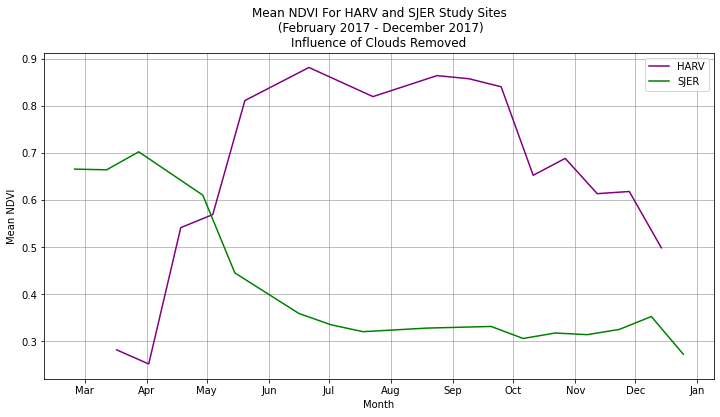

In [11]:
# Add only the plot code to this cell

# This is the final figure of mean NDVI
# for both sites across the year
# with data cleaned to deal with clouds

# YOUR CODE HERE

# Set a list of sites to loop through
plot_sites = ['HARV', 'SJER']
# Set a list of unique colors
plot_colors = ['purple', 'green']

# Set figure
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through dataframe and plot NDVI for each site using assigned color
for idx, asite in enumerate(plot_sites):
    temp = ndvi_clean[ndvi_clean['site']==asite]
    ax.plot(temp.index,
            temp.mean_ndvi,
            label=plot_sites[idx],
            color = plot_colors[idx])
       
#Set plot title and axes labels
ax.set(title = "Mean NDVI For HARV and SJER Study Sites\n (February 2017 - \
December 2017)\nInfluence of Clouds Removed",
       xlabel = "Month",
       ylabel = "Mean NDVI")


# Add legend
plt.legend()

# Add grid
plt.grid(color='grey', linestyle='-', linewidth=0.5)

# Format dates on x axis
# Add month names
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
# Add ticks for each months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

### DO NOT REMOVE LINES BELOW ###
final_masked_solution = nb.convert_axes(plt, which_axes="current")

In [12]:
# Ignore this cell for the autograding tests


In [13]:
# Ignore this cell for the autograding tests


# Question 1 (10 points)

Imagine that you are planning NEON’s upcoming flight season to capture remote sensing data in these locations and want to ensure that you fly the area when the vegetation is the most green.

When would you recommend the flights take place for each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

YOUR ANSWER HERE
1. I would plan flights for HARV site starting from mid May and until the first week of October.
2. Flights for SJER would have to be planned for a short window between mid February and end of March.

# Question 2 (10 points)

How could you modify your workflow to look at vegetation changes over time in each site? 

Answer the question in 2-3 sentences in the Markdown cell below.

YOUR ANSWER HERE:

1. I would probably ended up making separate dataframes for each site.
2. I think, it may be good idea to process more landsat scenes (for few years). I can see seasonal changes on the data from one year, but long-term trend would be interesting to explore.
3. Would be interesting to compare NDVI pattern with tempreture and precipitation variations across years.

# Do not edit this cell! (10 points)

The notebook includes:
* additional Markdown cells throughout the notebook to describe: 
    * the data that you used - and where it is from
    * how data are being processing
    * how the code is optimized to run fast and be more concise

# Do not edit this cell! (20 points)

The notebook will also be checked for overall clean code requirements as specified at the **top** of this notebook. Some of these requirements include (review the top cells for more specifics): 

* Notebook begins at cell [1] and runs on any machine in its entirety.
* PEP 8 format is applied throughout (including lengths of comment and code lines).
* No additional code or imports in the notebook that is not needed for the workflow.
* Notebook is fully reproducible. This means:
   * reproducible paths using the os module.
   * data downloaded using code in the notebook.
   * all imports at top of notebook.

## BONUS - Export a  .CSV File to Share (10 points possible)

This is optional - if you export a **.csv** file with the columns specified above: Site, Date and NDVI Value you can get an additional 10 points.

* FULL CREDIT: File exists in csv format and contains the columns specified.
We will check your github repo for this file!


In [14]:
# Export final datafarame to csv stored in the outputs directory

# Check if output folder exists
# Create output folder if necessary

ndvi_output = os.path.join(
    'ndvi-automation', 
    'outputs'
)
    
if os.path.exists(ndvi_output):
    print('Output directory exists')
else:
    print('Output directory does not exist but it is being created.')
    os.makedirs(ndvi_output)

# Create path and filename
ndvi_output_csv = os.path.join(
    ndvi_output, 
    'ndvi_output.csv'
)

# Export final df to csv
ndvi_clean.to_csv(ndvi_output_csv)

# Check that output csv exists
if os.path.exists(ndvi_output_csv):
    print('Output CSV exists')
else:
    print('Oh no, final CSV does not exist in the outputs directory.')
    


Output directory exists
Output CSV exists
